# Persyaratan Teknis:
- Gunakan minimal dua operator pengolahan citra dasar (misalnya,
Gaussian blur, edge detection) untuk meningkatkan kualitas data.
- Implementasikan minimal dua metode detektor atau deskriptor fitur lokal
(misalnya, SIFT, SURF, ORB).
- Buat sistem untuk menemukan korespondensi antara beberapa citra
(misalnya, menggunakan keypoints matching) dan menerapkannya dalam
pengenalan.
- Bangun sistem pengenalan berbasis fitur yang mampu mengklasifikasikan
atau mengidentifikasi objek dalam citra secara otomatis.

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import graycomatrix, graycoprops

In [3]:
DATASET_PATH = Path('../dataset/Data')

train_paths = pd.read_csv(DATASET_PATH / "train_paths.csv")
valid_paths = pd.read_csv(DATASET_PATH / "valid_paths.csv")
test_paths = pd.read_csv(DATASET_PATH / "test_paths.csv")

In [4]:
class_mapping = {
    'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 'adenocarcinoma',
    'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 'large.cell.carcinoma',
    'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 'squamous.cell.carcinoma',
    'normal': 'normal'
}

# Map training classes to test classes
train_paths['class'] = train_paths['class'].map(class_mapping)
valid_paths['class'] = valid_paths['class'].map(class_mapping)

## Functions

In [11]:
def preprocess_image(image): # all good 
    # Apply Gaussian Blur
    blurred = cv2.medianBlur(image, 3)
    # Apply Edge Detection (Canny)
    # edges = cv2.Canny(blurred, 100, 200)
    return blurred

def load_images(annotation): # all good
    images = []
    # heights = []
    # widhts = []
    for path in annotation['path'].values:
        image = cv2.imread(path, flags=cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (256, 256))
        image = preprocess_image(image)
        images.append(image)
        # heights.append(np.shape(image)[0])
        # widhts.append(np.shape(image)[1])
    # print((np.min(heights) - np.max(heights)) // 2)
    # print((np.min(widhts) - np.max(widhts)) // 2)
    return np.array(images)

train_images = load_images(train_paths)
valid_images = load_images(valid_paths)
test_images = load_images(test_paths)

In [ ]:
np.save('../tensors/train_images.npy', train_images)

In [6]:
# Step 1: Extract Histogram, Sobel, and Texture Features
def extract_combined_features(images, max_descriptors=100):
    sift = cv2.SIFT_create()
    kaze = cv2.KAZE_create()
    combined_features = []
    
    for image in tqdm(images, desc="Extracting SIFT + KAZE features"):
        # Sobel Edge Detection
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=11)
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=11)
        sobel_edges = cv2.magnitude(sobel_x, sobel_y)
        
        # Texture Features (Haralick features)
        sobel_edges_uint8 = np.uint8(sobel_edges / np.max(sobel_edges) * 255)
        glcm = graycomatrix(sobel_edges_uint8, distances=[1], angles=[0], levels=256)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        
        # Histogram of Sobel edges
        sobel_hist, _ = np.histogram(sobel_edges.ravel(), bins=256, range=(0, 255), density=True)
        sobel_hist = sobel_hist / np.sum(sobel_hist)  # Normalized histogram
        
        # SIFT Features
        _, sift_descriptors = sift.detectAndCompute(image, None)
        if sift_descriptors is None:
            sift_descriptors = np.zeros((0, 128), dtype=np.float32)
        elif sift_descriptors.shape[0] > max_descriptors:
            sift_descriptors = sift_descriptors[:max_descriptors]
        else:
            sift_descriptors = np.pad(
                sift_descriptors, 
                ((0, max_descriptors - sift_descriptors.shape[0]), (0, 0)), 
                'constant'
            ).astype(np.float32)

        # kaze Features
        _, kaze_descriptors = kaze.detectAndCompute(image, None)
        if kaze_descriptors is None:
            kaze_descriptors = np.zeros((0, 32), dtype=np.float32)
        elif kaze_descriptors.shape[0] > max_descriptors:
            kaze_descriptors = kaze_descriptors[:max_descriptors]
        else:
            kaze_descriptors = np.pad(
                kaze_descriptors, 
                ((0, max_descriptors - kaze_descriptors.shape[0]), (0, 0)), 
                'constant'
            ).astype(np.float32)

        # Concatenate histogram, Sobel, texture features, and SIFT + kaze descriptors
        combined_feature = np.concatenate([sobel_hist, [contrast, correlation, energy, homogeneity], sift_descriptors.flatten(), kaze_descriptors.flatten()])
        combined_features.append(combined_feature)
    
    return combined_features


# Step 2: Prepare Data
train_features_combined = extract_combined_features(train_images)
valid_features_combined = extract_combined_features(valid_images)
test_features_combined = extract_combined_features(test_images)

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features_combined)
valid_features = scaler.transform(valid_features_combined)
test_features = scaler.transform(test_features_combined)

# Encode labels
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_paths['class'])
encoded_valid_labels = label_encoder.transform(valid_paths['class'])
encoded_test_labels = label_encoder.transform(test_paths['class'])

Extracting SIFT + KAZE features:   0%|          | 0/613 [00:00<?, ?it/s]

Extracting SIFT + KAZE features:   0%|          | 0/72 [00:00<?, ?it/s]

Extracting SIFT + KAZE features:   0%|          | 0/315 [00:00<?, ?it/s]

In [ ]:
label_encoder.inverse_transform()

In [117]:
# Create the Random Forest model
xgb_model = XGBClassifier()

# Train the model
xgb_model.fit(train_features, encoded_train_labels)

# Make predictions on the test set
xgb_predictions = xgb_model.predict(test_features)

# Evaluate the model
print("Accuracy:", accuracy_score(encoded_test_labels, xgb_predictions))
print("Classification Report:\n", classification_report(encoded_test_labels, xgb_predictions))

Accuracy: 0.5650793650793651
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.70      0.58       120
           1       0.38      0.22      0.28        51
           2       0.98      0.91      0.94        54
           3       0.50      0.38      0.43        90

    accuracy                           0.57       315
   macro avg       0.59      0.55      0.56       315
weighted avg       0.56      0.57      0.55       315



In [118]:
label_encoder.classes_

array(['adenocarcinoma', 'large.cell.carcinoma', 'normal',
       'squamous.cell.carcinoma'], dtype=object)

In [121]:
import pickle

with open("../models/xgb.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

In [122]:
with open("../models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [8]:
import pickle

with open("../models/encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [ ]:
with open("../models/scaler.pkl", "rb") as f:
    model_load = pickle.load(f)
    
model_load

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Matcher

Matching Query with Train Images: 0it [00:00, ?it/s]

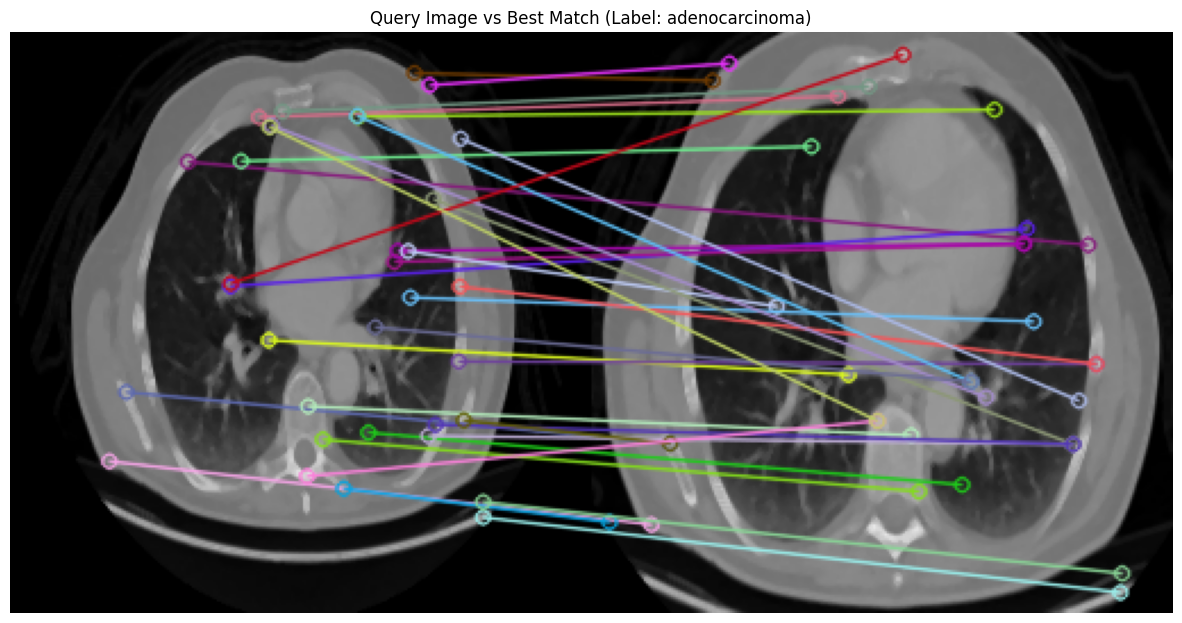

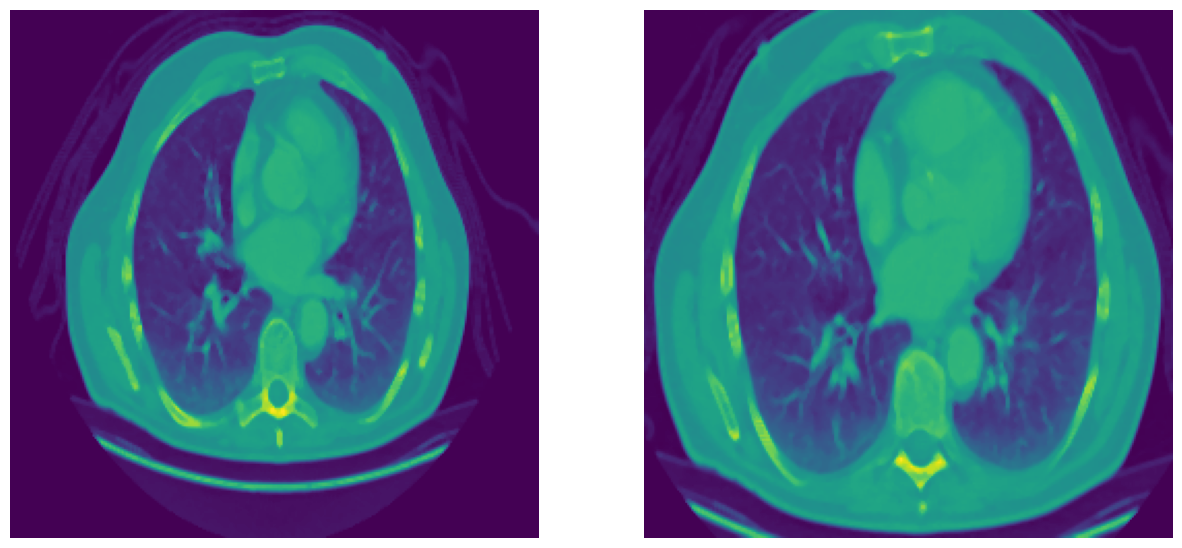

Best Match Label: adenocarcinoma
Test Label: adenocarcinoma


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

train_labels = train_paths['class'].values 
valid_labels = valid_paths['class'].values 
test_labels = test_paths['class'].values 

# Step 1: Combine SIFT and kaze Features
def extract_combined_features(image, upper_limit=None):
    # SIFT Feature Extraction
    sift = cv2.SIFT_create(nfeatures=100)
    keypoints_sift, descriptors_sift = sift.detectAndCompute(image, None)

    # kaze Feature Extraction
    kaze = cv2.KAZE_create()
    keypoints_kaze, descriptors_kaze = kaze.detectAndCompute(image, None)

    # Handle None descriptors
    if descriptors_sift is None:
        descriptors_sift = np.zeros((1, 128))
    if descriptors_kaze is None:
        descriptors_kaze = np.zeros((1, 32))

    if len(descriptors_sift) > 0:
        norms_sift = np.linalg.norm(descriptors_sift, axis=1, keepdims=True)
        descriptors_sift = descriptors_sift / (norms_sift + 1e-7)  # Avoid division by zero

    # Flatten and concatenate
    combined_features = np.concatenate(
        [descriptors_sift.flatten(), descriptors_kaze.flatten()]
    )

    combined_kp = keypoints_sift, keypoints_kaze

    # Ensure fixed size (upper_limit) by padding or truncating
    if upper_limit == None:
        return combined_features
    elif len(combined_features) < upper_limit:
        combined_features = np.pad(combined_features, (0, upper_limit - len(combined_features)))
    else:
        combined_features = combined_features[:upper_limit]

    return combined_kp, combined_features

# Step 2: Extract Features from Dataset
def extract_features(images, upper_limit=10):
    features = []
    for image in images:
        combined_features = extract_combined_features(image, upper_limit)
        features.append(combined_features)
    return np.array(features)

def cosine_similarity(vec1, vec2):
    """Compute cosine similarity between two vectors."""
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2 + 1e-7)

# BFMatcher function
def create_matcher(matcher_type="BF"):
    if matcher_type == "FLANN":
        index_params = dict(algorithm=1, trees=5)  # FLANN parameters
        search_params = dict(checks=50)  # Search parameters
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
    elif matcher_type == "BF":
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)  # BFMatcher with L2 norm
    else:
        raise ValueError("Invalid matcher type. Choose 'FLANN' or 'BF'.")
    return matcher

# Match and visualize matches
def classify_and_plot_matches(query_image, train_images, train_labels, upper_limit=10, matcher_type="BF"):
    """
    Classify the query image by finding the best match among the training images
    based on combined SIFT and KAZE features and visualize matches using BFMatcher or FLANN.
    
    Parameters:
    - query_image: The query image.
    - train_images: List of training images.
    - train_labels: Labels for the training images.
    - upper_limit: Maximum size for the feature vector.
    - matcher_type: Type of matcher ("BF" or "FLANN").
    
    Returns:
    - best_label: The label of the best-matching training image.
    """
    # Extract combined features for the query image
    query_kp, query_features = extract_combined_features(query_image, upper_limit)

    best_label = None
    best_index = -1
    best_similarity = -1  # Start with the worst similarity
    best_train_image = None

    # Compare with each training image
    for i, train_image in tqdm(enumerate(train_images), desc="Matching Query with Train Images"):
        _, train_features = extract_combined_features(train_image, upper_limit)
        similarity = cosine_similarity(query_features, train_features)

        if similarity > best_similarity:
            best_similarity = similarity
            best_label = train_labels[i]
            best_index = i
            best_train_image = train_image

    # Prepare matcher
    matcher = create_matcher(matcher_type)

    # Use both SIFT and KAZE for keypoints and descriptors
    sift = cv2.SIFT_create()
    kaze = cv2.KAZE_create()

    # Extract SIFT and KAZE keypoints and descriptors for the query image
    query_kp_sift, query_desc_sift = sift.detectAndCompute(query_image, None)
    query_kp_kaze, query_desc_kaze = kaze.detectAndCompute(query_image, None)

    # Extract SIFT and KAZE keypoints and descriptors for the best matching training image
    train_kp_sift, train_desc_sift = sift.detectAndCompute(best_train_image, None)
    train_kp_kaze, train_desc_kaze = kaze.detectAndCompute(best_train_image, None)

    # Ensure descriptors are not None
    if query_desc_sift is None:
        query_desc_sift = np.zeros((1, 128))  # SIFT descriptor size
    if query_desc_kaze is None:
        query_desc_kaze = np.zeros((1, 64))  # KAZE descriptor size

    if train_desc_sift is None:
        train_desc_sift = np.zeros((1, 128))
    if train_desc_kaze is None:
        train_desc_kaze = np.zeros((1, 64))

    # Match the size of descriptors by padding the smaller one
    if len(query_desc_sift) < len(query_desc_kaze):
        query_desc_sift = np.pad(query_desc_sift, ((0, len(query_desc_kaze) - len(query_desc_sift)), (0, 0)), 'constant')
    elif len(query_desc_kaze) < len(query_desc_sift):
        query_desc_kaze = np.pad(query_desc_kaze, ((0, len(query_desc_sift) - len(query_desc_kaze)), (0, 0)), 'constant')

    if len(train_desc_sift) < len(train_desc_kaze):
        train_desc_sift = np.pad(train_desc_sift, ((0, len(train_desc_kaze) - len(train_desc_sift)), (0, 0)), 'constant')
    elif len(train_desc_kaze) < len(train_desc_sift):
        train_desc_kaze = np.pad(train_desc_kaze, ((0, len(train_desc_sift) - len(train_desc_kaze)), (0, 0)), 'constant')

    # Combine descriptors from both SIFT and KAZE
    query_desc_combined = np.hstack((query_desc_sift, query_desc_kaze))
    train_desc_combined = np.hstack((train_desc_sift, train_desc_kaze))

    # Match descriptors using BFMatcher or FLANN
    matches = matcher.knnMatch(query_desc_combined, train_desc_combined, k=2)

    # Apply ratio test (Lowe's ratio test)
    good_matches = [m for m, n in matches if m.distance < 0.8 * n.distance]

    # Draw matches
    match_img = cv2.drawMatchesKnn(
        query_image, query_kp_sift + query_kp_kaze,  # Combined keypoints (SIFT + KAZE)
        best_train_image, train_kp_sift + train_kp_kaze,  # Combined keypoints (SIFT + KAZE)
        [[m] for m in good_matches],
        None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Visualize the query image and best-matching training image along with matches
    plt.figure(figsize=(15, 10))
    plt.title(f"Query Image vs Best Match (Label: {best_label})")
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    plt.axis(False)

    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(query_image)
    plt.axis(False)
    plt.subplot(1, 2, 2)
    plt.imshow(best_train_image)
    plt.axis(False)
    plt.show()

    return best_label

# Example Usage:
# Assuming `train_images` and `train_labels` contain the training data and labels,
# and `query_image` is the input image to classify.
from random import randint
random_idx = randint(0, len(test_paths)-1)
test_label = test_paths.iloc[random_idx, 1]
test_image = test_images[random_idx]  # Replace with any test image
best_label = classify_and_plot_matches(test_image, train_images, train_labels, upper_limit=1024)
print(f"Best Match Label: {best_label}")
print(f"Test Label: {test_label}")

In [14]:
np.save('../tensors/train_labels.npy', train_labels)

# Using bag of words

In [8]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer

def extract_descriptors(images, feature_extractor, max_descriptors=100):
    descriptors_list = []
    for image in tqdm(images, desc=f"Extracting {feature_extractor} descriptors"):
        if feature_extractor == 'SIFT':
            detector = cv2.SIFT_create()
        elif feature_extractor == 'KAZE':
            detector = cv2.KAZE_create()
        else:
            raise ValueError("Invalid feature extractor. Use 'SIFT' or 'KAZE'.")
        
        _, descriptors = detector.detectAndCompute(image, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
    
    return descriptors_list

# Step 1: Extract descriptors for training images
sift_descriptors_list = extract_descriptors(train_images, 'SIFT')
kaze_descriptors_list = extract_descriptors(train_images, 'KAZE')

# Combine all descriptors from all training images
all_sift_descriptors = np.vstack([desc for desc in sift_descriptors_list if desc is not None])
all_kaze_descriptors = np.vstack([desc for desc in kaze_descriptors_list if desc is not None])

# Step 2: Perform k-means clustering to create visual words
num_clusters = 100  # Number of visual words
print("Clustering descriptors to form visual words...")
kmeans_sift = KMeans(n_clusters=num_clusters, random_state=42).fit(all_sift_descriptors)
kmeans_kaze = KMeans(n_clusters=num_clusters, random_state=42).fit(all_kaze_descriptors)

# Step 3: Quantize descriptors of each image into histograms
def create_histograms(descriptors_list, kmeans):
    histograms = []
    for descriptors in descriptors_list:
        if descriptors is not None:
            # Assign descriptors to the nearest cluster centers
            words = kmeans.predict(descriptors)
            # Create a histogram of word occurrences
            histogram, _ = np.histogram(words, bins=np.arange(kmeans.n_clusters + 1), density=True)
        else:
            histogram = np.zeros(kmeans.n_clusters)
        histograms.append(histogram)
    return histograms

train_sift_histograms = create_histograms(sift_descriptors_list, kmeans_sift)
train_kaze_histograms = create_histograms(kaze_descriptors_list, kmeans_kaze)

# Step 4: Concatenate SIFT and KAZE histograms for each image
train_bow_features = np.hstack([train_sift_histograms, train_kaze_histograms])

# Repeat the process for validation and test sets
valid_sift_descriptors = extract_descriptors(valid_images, 'SIFT')
valid_kaze_descriptors = extract_descriptors(valid_images, 'KAZE')
valid_sift_histograms = create_histograms(valid_sift_descriptors, kmeans_sift)
valid_kaze_histograms = create_histograms(valid_kaze_descriptors, kmeans_kaze)
valid_bow_features = np.hstack([valid_sift_histograms, valid_kaze_histograms])

test_sift_descriptors = extract_descriptors(test_images, 'SIFT')
test_kaze_descriptors = extract_descriptors(test_images, 'KAZE')
test_sift_histograms = create_histograms(test_sift_descriptors, kmeans_sift)
test_kaze_histograms = create_histograms(test_kaze_descriptors, kmeans_kaze)
test_bow_features = np.hstack([test_sift_histograms, test_kaze_histograms])

Extracting SIFT descriptors:   0%|          | 0/613 [00:00<?, ?it/s]

Extracting KAZE descriptors:   0%|          | 0/613 [00:00<?, ?it/s]

Clustering descriptors to form visual words...


Extracting SIFT descriptors:   0%|          | 0/72 [00:00<?, ?it/s]

Extracting KAZE descriptors:   0%|          | 0/72 [00:00<?, ?it/s]

Extracting SIFT descriptors:   0%|          | 0/315 [00:00<?, ?it/s]

Extracting KAZE descriptors:   0%|          | 0/315 [00:00<?, ?it/s]

In [29]:
# PCA for dimensionality reduction
pca = PCA(n_components=0.95)
train_bow_features = pca.fit_transform(train_bow_features)
valid_bow_features = pca.transform(valid_bow_features)
test_bow_features = pca.transform(test_bow_features)

# TF-IDF Transformation
tfidf_transformer = TfidfTransformer()
train_bow_features = tfidf_transformer.fit_transform(train_bow_features).toarray()
valid_bow_features = tfidf_transformer.transform(valid_bow_features).toarray()
test_bow_features = tfidf_transformer.transform(test_bow_features).toarray()

# Gradient Boosting Classifier
from xgboost import XGBClassifier
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.05)
xgb_model.fit(train_bow_features, encoded_train_labels)
xgb_predictions = xgb_model.predict(test_bow_features)

# Evaluate
print("Accuracy:", accuracy_score(encoded_test_labels, xgb_predictions))
print("Classification Report:\n", classification_report(encoded_test_labels, xgb_predictions))

Accuracy: 0.5936507936507937
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.56      0.55       120
           1       0.41      0.69      0.51        51
           2       0.96      1.00      0.98        54
           3       0.60      0.34      0.44        90

    accuracy                           0.59       315
   macro avg       0.63      0.65      0.62       315
weighted avg       0.61      0.59      0.59       315



# Combined BoW and Statistical Features from sobels

In [30]:
# Step 1: Extract Sobel, Texture, and BoW Features
def extract_combined_features_with_bow(images, bow_features, max_descriptors=100):
    combined_features = []
    
    for i, image in enumerate(tqdm(images, desc="Extracting Combined Features")):
        # Sobel Edge Detection
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=11)
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=11)
        sobel_edges = cv2.magnitude(sobel_x, sobel_y)
        
        # Texture Features (Haralick features)
        sobel_edges_uint8 = np.uint8(sobel_edges / np.max(sobel_edges) * 255)
        glcm = graycomatrix(sobel_edges_uint8, distances=[1], angles=[0], levels=256)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        
        # Histogram of Sobel edges
        sobel_hist, _ = np.histogram(sobel_edges.ravel(), bins=256, range=(0, 255), density=True)
        sobel_hist = sobel_hist / np.sum(sobel_hist)  # Normalized histogram

        # Add BoW features for the corresponding image
        bow_feature = bow_features[i]
        
        # Concatenate histogram, texture features, and BoW features
        combined_feature = np.concatenate([sobel_hist, [contrast, correlation, energy, homogeneity], bow_feature])
        combined_features.append(combined_feature)
    
    return combined_features


# Step 2: Prepare BoW Features (Already extracted in previous steps)
# Use the precomputed BoW histograms for train, validation, and test sets

# Step 3: Combine Features
train_features_combined = extract_combined_features_with_bow(train_images, train_bow_features)
valid_features_combined = extract_combined_features_with_bow(valid_images, valid_bow_features)
test_features_combined = extract_combined_features_with_bow(test_images, test_bow_features)

# Step 4: Normalize Features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features_combined)
valid_features = scaler.transform(valid_features_combined)
test_features = scaler.transform(test_features_combined)

# Step 5: Encode Labels
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_paths['class'])
encoded_valid_labels = label_encoder.transform(valid_paths['class'])
encoded_test_labels = label_encoder.transform(test_paths['class'])

# Step 6: Train Model
rf_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.05)
rf_model.fit(train_features, encoded_train_labels)

# Step 7: Evaluate Model
rf_predictions = rf_model.predict(test_features)

print("Accuracy:", accuracy_score(encoded_test_labels, rf_predictions))
print("Classification Report:\n", classification_report(encoded_test_labels, rf_predictions))

Extracting Combined Features:   0%|          | 0/613 [00:00<?, ?it/s]

Extracting Combined Features:   0%|          | 0/72 [00:00<?, ?it/s]

Extracting Combined Features:   0%|          | 0/315 [00:00<?, ?it/s]

Accuracy: 0.4984126984126984
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.28      0.37       120
           1       0.25      0.51      0.34        51
           2       0.98      0.96      0.97        54
           3       0.45      0.51      0.48        90

    accuracy                           0.50       315
   macro avg       0.56      0.56      0.54       315
weighted avg       0.56      0.50      0.50       315

